# Evaluation, Prediction & Visualization for the Best Model

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import numpy as np
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import TALOS_DIR
from app.preprocessing import load_dataset, load_embeddings, preprocess_data
from app.models import load_model, find_best_model_over_scan_logs


Using TensorFlow backend.


### Find the Best Model Against the Talos Scans

In [4]:

# TF-IDF configuration filepath 
# TALOS_TF_LOG_FILENAME = 'talos_tf_log_.csv'
TALOS_TF_LOG_FILENAME = 'talos_tf_log_test_.csv'
talos_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_TF_LOG_FILENAME)

# TALOS_SDR_TF_LOG_FILENAME = 'talos_sdr_tf_log_.csv'
TALOS_SDR_TF_LOG_FILENAME = 'talos_sdr_tf_log_test_.csv'
talos_sdr_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_TF_LOG_FILENAME)
# Embeddings Centroids configuration filepath
# TALOS_FTC_LOG_FILENAME = 'talos_ftc_test_.csv'
TALOS_FTC_LOG_FILENAME = 'talos_ftc_log_test_.csv'
talos_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_FTC_LOG_FILENAME)

# TALOS_SDR_FTC_LOG_FILENAME = 'talos_sdr_ftc_log_.csv'
TALOS_SDR_FTC_LOG_FILENAME = 'talos_sdr_ftc_log_test_.csv'
talos_sdr_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_FTC_LOG_FILENAME)

best_model_params = find_best_model_over_scan_logs('val_f1', *[talos_tf_log_pathname,
                                                               talos_ftc_log_pathname,
                                                               talos_sdr_tf_log_pathname,
                                                               talos_sdr_ftc_log_pathname])


    Check the model type and load the relevant processed data

In [5]:
best_model_params

{'round_epochs': 10,
 'val_loss': 0.5963163259483519,
 'val_f1': 0.7820719531604222,
 'val_accuracy': 0.9824107067925588,
 'loss': 0.12635106059209425,
 'f1': 0.8224419460491258,
 'accuracy': 0.9960510167297052,
 'visualize_proccess': False,
 'first_neuron': 128,
 'activation': 'tanh',
 'dropout': 0.4,
 'number_of_hidden_layers': 1,
 'shapes': 'funnel',
 'epochs': 10,
 'batch_size': 32,
 'model_type': 'keras_tf_idf_model'}

In [6]:
data = load_dataset(load_from_pickle=True)
Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)

if best_model_params['model_type'] == 'keras_tf_idf_model':
    model_data = preprocess_data(data, 'tags', 'post',
                                 input_ins='as_tf_idf',
                                 cv_split_full=0.3,
                                 cv_split_dev=0.3) 
else:
    embeddings = load_embeddings(data, 'post', minimized=False)
    model_data = preprocess_data(data, 'tags', 'post',
                                 input_ins='as_centroids',
                                 cv_split_full=0.3,
                                 cv_split_dev=0.3,
                                 embeddings=embeddings)

    Train the model with the best params

In [7]:
model_history, model = load_model(model_data['x_train'],
                                  model_data['y_train'],
                                  model_data['x_train_dev'],
                                  model_data['y_train_dev'],
                                  best_model_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


 ### Visualize Model History Scores

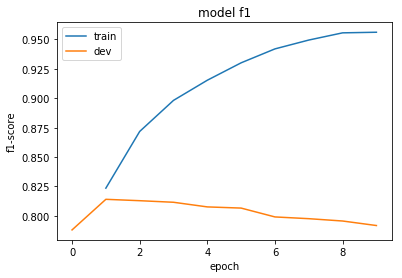

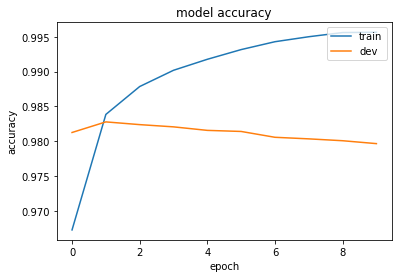

In [8]:
from app.visualization import plot_history_metrics
%matplotlib inline
plot_history_metrics(model_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [9]:
score = model.evaluate(model_data['x_test'],
                       model_data['y_test'],
                       batch_size=best_model_params['batch_size'],
                       verbose=1)

print('\nTest f1: %.4f' % (score[1]))
print('\nTest accuracy: %.4f'% (score[2]))

12000/12000 [==============================] - 1s 52us/step

Test f1: 0.7852

Test accuracy: 0.9790


### Visualize Prediction Perfomance of centroids MLP model

--------------------------------------------------------------------------------
Accuracy Score: 78.06%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.632     0.645     0.639       600
           1      0.932     0.888     0.910       600
           2      0.991     0.957     0.974       600
           3      0.803     0.732     0.765       600
           4      0.805     0.830     0.817       600
           5      0.598     0.630     0.614       600
           6      0.794     0.783     0.789       600
           7      0.792     0.850     0.820       600
           8      0.656     0.678     0.667       600
           9      0.602     0.617     0.609       600
          10      0.658     0.628     0.643       600
          11      0.801     0.813     0.807       600
       

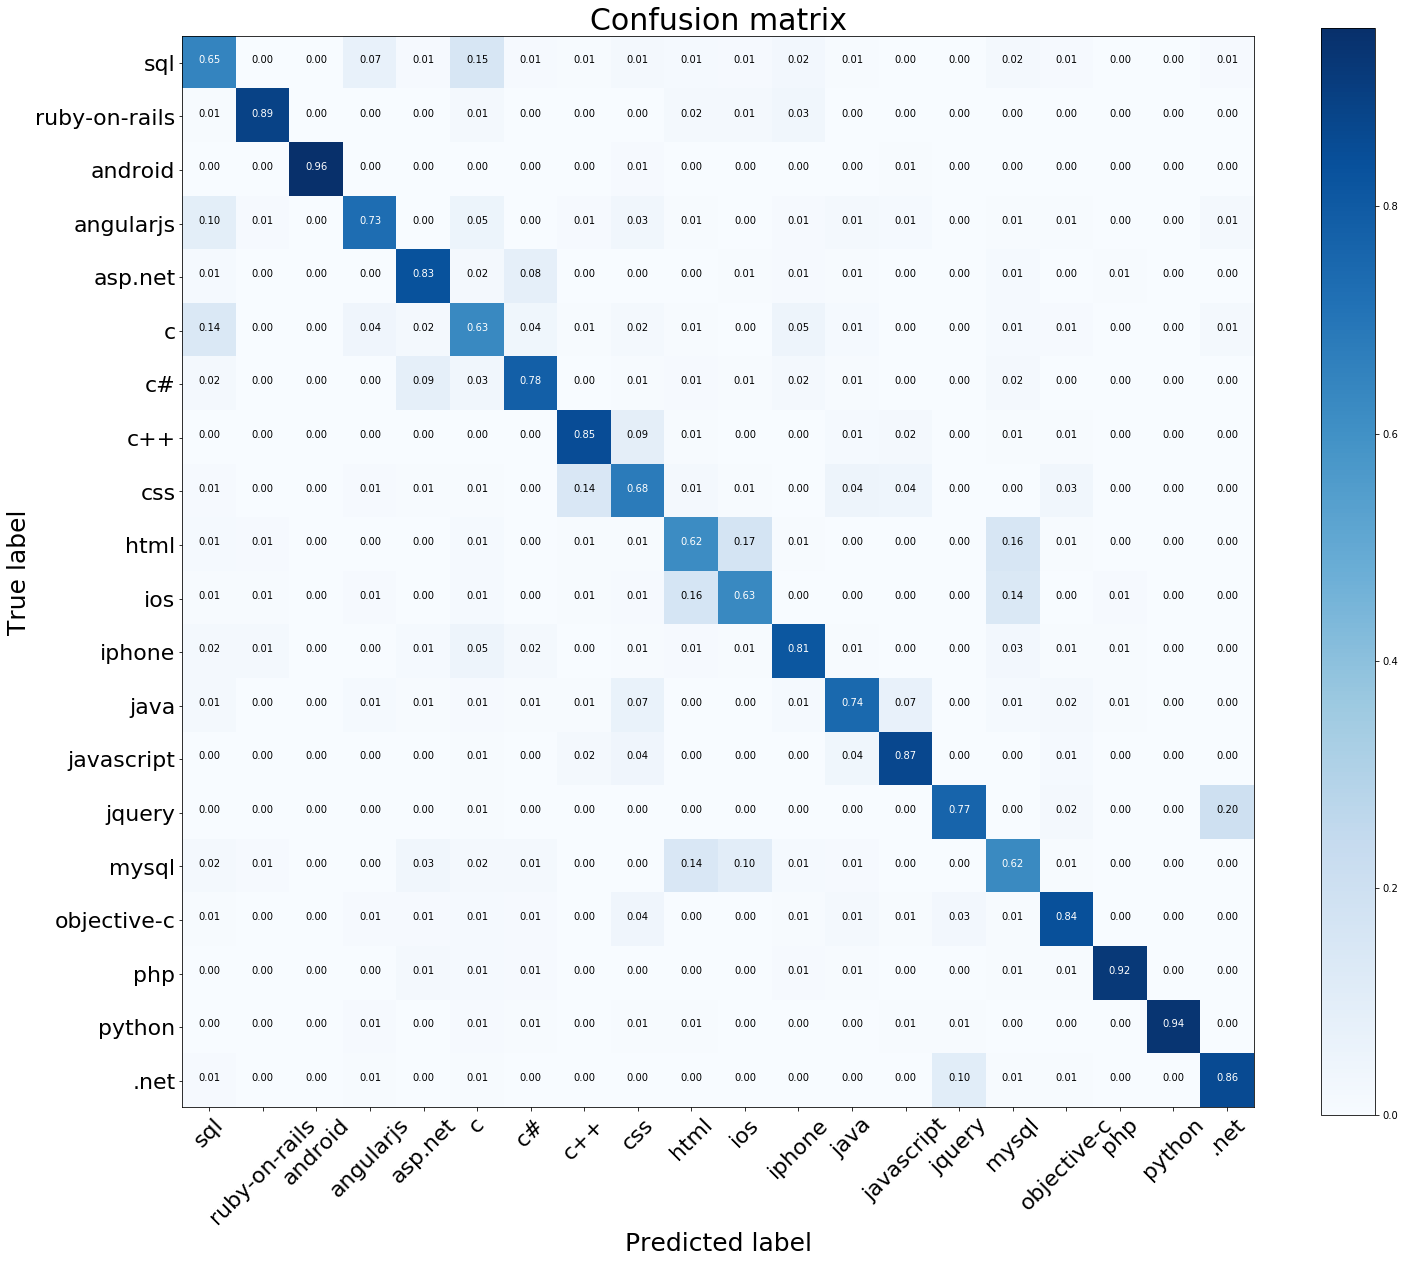

In [10]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val = model.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed = np.array([np.argmax(val) for val in prediction_val])
y_true_processed = np.array([np.argmax(val) for val in model_data['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed, y_pred_processed, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed, y_pred_processed, Classes)

## Comparison with a simple SVM Classifier

In this section we want to distinguish whether a simple Linear classifier could have the same Performance as the tested
NN models.

In [ ]:
##SVM classifier
#Random Grid Search with cross validation
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

# Parameter Tuning
grid_params4 = {
    'C':[0.001,0.01,1,10],
    'kernel':['linear','rbf','poly'],
    'gamma':['auto','scale']
}

#stratified KFold is used by default
simple_classifier = RandomizedSearchCV(svm.SVC(),
                                       grid_params4,
                                       scoring='f1_macro', 
                                       cv=5, n_jobs=-1, n_iter=5, 
                                       random_state=12)

# Transforming model data to fit for the RandomSearchCV model using SVC classifierr
text_full_train = np.vstack((model_data['x_train'],model_data['x_train_dev']))
labels_full_train = np.vstack((model_data['y_train'],model_data['y_train_dev']))
labels_full_train = np.array([np.argmax(val) for val in labels_full_train])
labels_true = np.array([np.argmax(val) for val in model_data['y_test']])

print(text_full_train.shape, labels_full_train.shape)

In [ ]:
simple_classifier.fit(text_full_train, labels_full_train)

score_train_svm = simple_classifier.best_score_

print("Best Score: ", np.round(simple_classifier.best_score_,4))
print("Best Params: ", simple_classifier.best_params_)

In [ ]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

labels_prediction = simple_classifier.predict(model_data['x_test'])

# If you want to get the Classification Report, comment out the below line
create_clf_report(labels_true, labels_prediction, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(labels_true, labels_prediction, Classes)